# Proyecto Final — Detección de Anomalías de SO₂ en CDMX (2008 vs 2011)

**Objetivo:** Construir unotebookta para integrar lo aprendido en MEIA 2023:
- Análisis de contaminantes (carga, limpieza, EDA).
- Reducción de dimensionalidad y *unsupervised learning*.
- Detección de anomalías con varios métodos y comité de modelos.

**Datos:** Concentración horaria de SO₂ por estación en CDMX para 2008 y 2011 (archivos CSV provistos).  
**Salida:** Reporte con visualizaciones + CSV de anomalías detectadas pcesidades.


In [4]:
# !pip install umap-learn deap --quiet  # (opcional) si el entorno lo permite

from pathlib import Path
import warnings, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from sklearn.ensemble import IsolationForest

# UMAP opcional
try:
    import umap
    HAS_UMAP = True
except:
    HAS_UMAP = False

# DEAP opcional (optimización evolutiva)
try:
    from deap import base, creator, tools, algorithms
    HAS_DEAP = True
except:
    HAS_DEAP = False

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (8,5)

DATA_2008 = Path('data/CMX-SO2-2008.csv')
DATA_2011 = Path('data/CMX-SO2-2011.csv')

assert DATA_2008.exists() and DATA_2011.exists()
print("Rutas OK:", DATA_2008, DATA_2011)


Rutas OK: data\CMX-SO2-2008.csv data\CMX-SO2-2011.csv


In [6]:
def load_so2(path: Path, year: int) -> pd.DataFrame:
    df = pd.read_csv(path)
    df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True, errors='coerce')

    if df['Hora'].dtype.kind in 'iu':  # hora como entero
        df['Hora'] = df['Hora'].astype(int).clip(0,23)
        dt = df['Fecha'] + pd.to_timedelta(df['Hora'], unit='h')
    else:  # hora como string HH:MM
        h = pd.to_datetime(df['Hora'].astype(str), format='%H:%M', errors='coerce').dt.hour
        dt = df['Fecha'] + pd.to_timedelta(h.fillna(0).astype(int), unit='h')

    df = df.set_index(dt).drop(columns=['Fecha','Hora'])
    df.index.name = 'datetime'
    df = df.apply(pd.to_numeric, errors='coerce')
    df['year'] = year
    return df

df08 = load_so2(DATA_2008, 2008)
df11 = load_so2(DATA_2011, 2011)

all_stations = sorted(set(df08.columns).union(df11.columns) - {'year'})
df08 = df08.reindex(columns=all_stations + ['year'])
df11 = df11.reindex(columns=all_stations + ['year'])

df_wide = pd.concat([df08, df11]).sort_index()
print("Rango temporal:", df_wide.index.min(), "→", df_wide.index.max())
print("Estaciones:", len(all_stations))
df_wide.head()


Rango temporal: 2008-01-01 00:00:00 → 2011-12-12 23:00:00
Estaciones: 32


,ACO,ARA,ATI,AZC,CAM,CES,CHO,CUA,FAC,IZT,...,TAH,TAX,TLA,TLI,TPN,UIZ,VAL,VIF,XAL,year
datetime,,,,,,,,,,,,,,,,,,,,,
2008-01-01 00:00:00,3.0,4.0,19.0,23.0,NaN,8.0,6.0,NaN,13.0,10.0,...,4.0,7.0,26.0,NaN,NaN,10.0,10.0,13.0,4.0,2008
2008-01-01 01:00:00,7.0,13.0,10.0,28.0,NaN,9.0,7.0,NaN,11.0,16.0,...,5.0,7.0,20.0,NaN,NaN,11.0,16.0,16.0,9.0,2008
2008-01-01 02:00:00,10.0,11.0,5.0,13.0,NaN,10.0,8.0,NaN,9.0,15.0,...,3.0,8.0,21.0,NaN,NaN,11.0,13.0,20.0,13.0,2008
2008-01-01 03:00:00,7.0,11.0,3.0,10.0,NaN,8.0,9.0,NaN,7.0,14.0,...,4.0,9.0,11.0,NaN,NaN,10.0,12.0,13.0,13.0,2008
2008-01-01 04:00:00,7.0,7.0,1.0,5.0,NaN,8.0,6.0,NaN,6.0,8.0,...,4.0,6.0,7.0,11.0,NaN,8.0,10.0,11.0,11.0,2008


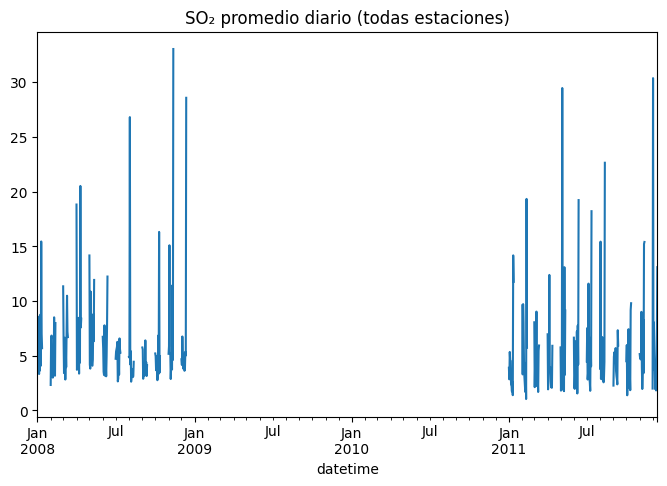

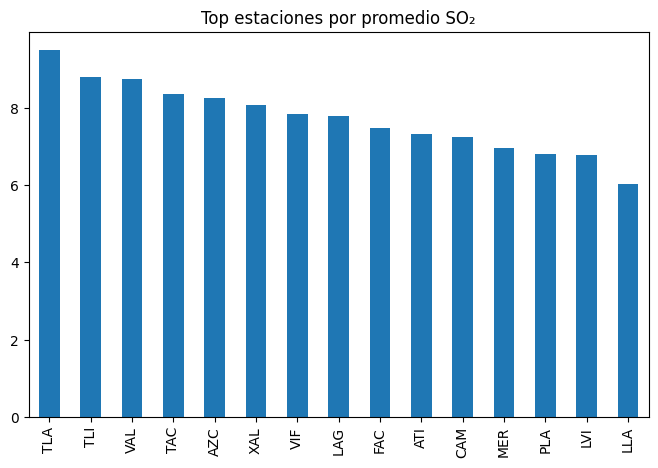

In [7]:
coverage = df_wide.groupby('year')[all_stations].apply(lambda x: x.notna().mean()).T
coverage.head()

city_mean = df_wide[all_stations].mean(axis=1)
city_mean.resample('D').mean().plot(title="SO₂ promedio diario (todas estaciones)")
plt.show()

station_means = df_wide[all_stations].mean().sort_values(ascending=False)
station_means.head(15).plot(kind='bar', title="Top estaciones por promedio SO₂")
plt.show()


In [8]:
def daily_features(df: pd.DataFrame, stations: list) -> pd.DataFrame:
    grouped = df[stations].resample('D')
    mean = grouped.mean()
    p95  = grouped.quantile(0.95)
    feats = pd.concat({'mean': mean, 'p95': p95}, axis=1)
    feats.columns = [f"{stat}_{st}" for stat, st in feats.columns]
    feats['year'] = feats.index.year
    return feats

daily_df = daily_features(df_wide, all_stations).dropna(how='all')
daily_df.head()

,mean_ACO,mean_ARA,mean_ATI,mean_AZC,mean_CAM,mean_CES,mean_CHO,mean_CUA,mean_FAC,mean_IZT,...,p95_TAH,p95_TAX,p95_TLA,p95_TLI,p95_TPN,p95_UIZ,p95_VAL,p95_VIF,p95_XAL,year
datetime,,,,,,,,,,,,,,,,,,,,,
2008-01-01,4.333333,5.750000,5.666667,9.363636,NaN,4.666667,4.375000,NaN,5.333333,8.000000,...,4.7,7.90,20.85,9.20,NaN,11.00,12.9,17.80,12.85,2008
2008-01-02,1.684211,3.000000,3.250000,2.190476,NaN,3.625000,5.916667,NaN,6.650000,2.050000,...,1.0,1.00,11.00,5.00,NaN,6.90,8.0,6.35,12.10,2008
2008-01-03,1.842105,3.291667,9.571429,9.583333,NaN,4.500000,6.625000,NaN,6.541667,3.166667,...,NaN,5.85,39.35,NaN,NaN,NaN,NaN,NaN,15.85,2008
2008-01-04,1.333333,2.631579,3.875000,4.541667,NaN,5.318182,7.166667,NaN,3.695652,3.958333,...,3.8,6.90,10.70,7.85,NaN,NaN,10.0,NaN,19.95,2008
2008-01-05,2.416667,1.714286,1.777778,1.333333,NaN,3.125000,4.125000,NaN,2.791667,1.500000,...,1.0,3.00,7.70,5.00,NaN,7.55,6.0,4.00,12.85,2008


Varianza explicada: [0.46220585 0.16682813]


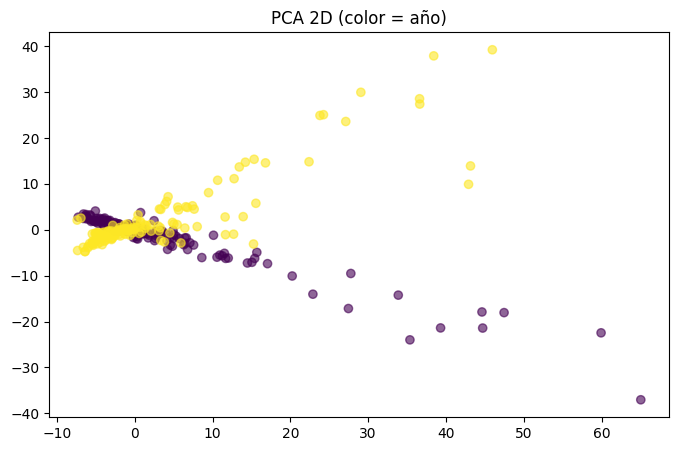

In [9]:
X = daily_df.drop(columns=['year']).fillna(daily_df.median())
scaler = StandardScaler()
Xz = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(Xz)
print("Varianza explicada:", pca.explained_variance_ratio_)

plt.scatter(X_pca[:,0], X_pca[:,1], c=daily_df['year'], alpha=0.6)
plt.title("PCA 2D (color = año)")
plt.show()


In [10]:
results = pd.DataFrame(index=daily_df.index)
results['year'] = daily_df['year']

# KMeans
kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
labels = kmeans.fit_predict(Xz)
centers = kmeans.cluster_centers_[labels]
km_dist = np.linalg.norm(Xz - centers, axis=1)
results['kmeans'] = (km_dist - km_dist.min()) / km_dist.ptp()

# KNN
def knn_score(X, k=20):
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    dists, _ = nbrs.kneighbors(X)
    kth = dists[:,-1]
    return (kth - kth.min())/kth.ptp()

results['knn'] = knn_score(Xz, 20)

# LOF
lof = LocalOutlierFactor(n_neighbors=20)
lof_scores = -lof.fit_predict(Xz)
results['lof'] = (-lof.negative_outlier_factor_ - (-lof.negative_outlier_factor_).min())/(-lof.negative_outlier_factor_).ptp()

# Isolation Forest
iso = IsolationForest(n_estimators=200, random_state=42)
iso.fit(Xz)
scores = -iso.score_samples(Xz)
results['iforest'] = (scores - scores.min())/scores.ptp()

# Ensemble
results['ensemble'] = results[['kmeans','knn','lof','iforest']].mean(axis=1)
results.head()


,year,kmeans,knn,lof,iforest,ensemble
datetime,,,,,,
2008-01-01,2008,0.160939,0.106121,8.735627e-01,0.333009,0.368408
2008-01-02,2008,0.115790,0.078548,1.648775e-01,0.229700,0.147229
2008-01-03,2008,0.150340,0.099379,6.936619e-01,0.225346,0.292182
2008-01-04,2008,0.139633,0.089858,1.915748e-12,0.225730,0.113805
2008-01-05,2008,0.113457,0.077654,8.153153e-02,0.278881,0.137881


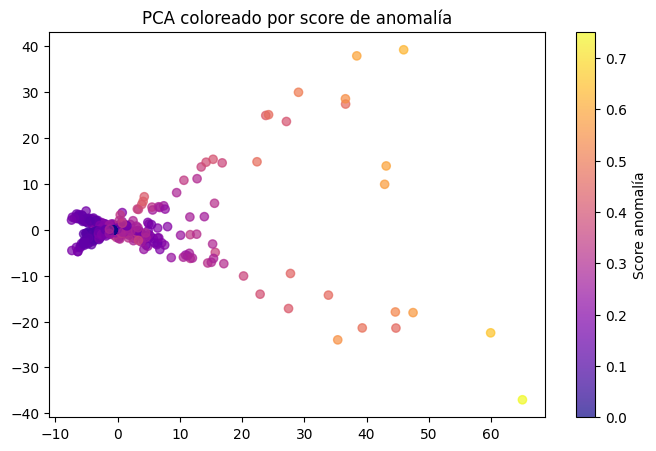

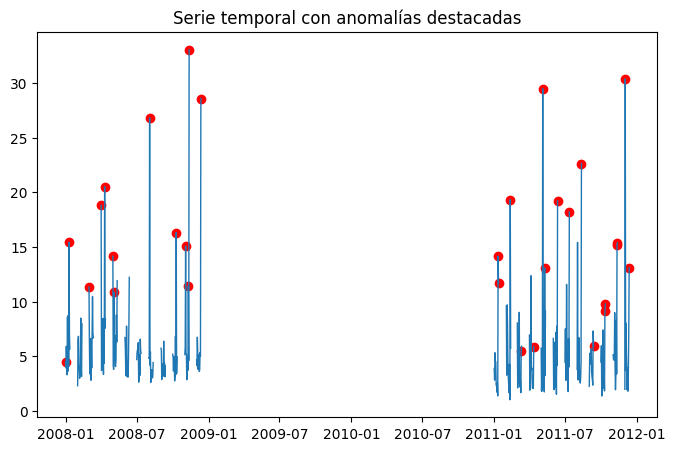

In [11]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=results['ensemble'], cmap="plasma", alpha=0.7)
plt.colorbar(label="Score anomalía")
plt.title("PCA coloreado por score de anomalía")
plt.show()

city_daily = df_wide[all_stations].mean(axis=1).resample('D').mean()
plt.plot(city_daily.index, city_daily.values, lw=1)
plt.scatter(results.sort_values('ensemble').tail(30).index,
            city_daily.loc[results.sort_values('ensemble').tail(30).index], c="red")
plt.title("Serie temporal con anomalías destacadas")
plt.show()


In [12]:
out_dir = Path("reportes"); out_dir.mkdir(exist_ok=True)

results['date'] = results.index.date
results.to_csv(out_dir/"anomaly_scores_daily.csv")
results.sort_values('ensemble', ascending=False).head(30).to_csv(out_dir/"top_anomalies.csv")

print("Archivos exportados en", out_dir.resolve())


Archivos exportados en C:\Users\landa\Downloads\MEIA_2023-20250905T050934Z-1-001\MEIA_2023\reportes
